<a href="https://colab.research.google.com/github/neohaky/deeplearning/blob/main/Tugas2_KlasifikasiGambar_4Kelas_(mobilenet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/Alat_dapur'  # Ganti path lo
classes = os.listdir(dataset_path)

# Daftar ekstensi yang didukung
supported_extensions = ['.jpg', '.jpeg', '.png', '.webp', '.JPG', '.JPEG']

# Cek gambar corrupt & format tidak didukung
corrupt_images = []
unsupported_files = []

for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)

        # Cek ekstensi file
        ext = os.path.splitext(img_name)[1]
        if ext not in supported_extensions:
            unsupported_files.append(img_path)
            continue

        # Cek gambar corrupt
        try:
            with Image.open(img_path) as img:
                img.convert('RGB')  # Coba convert ke RGB
        except:
            corrupt_images.append(img_path)

print(f"File tidak didukung: {len(unsupported_files)} (contoh: {unsupported_files[:3]})")
print(f"Gambar corrupt: {len(corrupt_images)} (contoh: {corrupt_images[:3]})")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File tidak didukung: 0 (contoh: [])
Gambar corrupt: 0 (contoh: [])


In [ ]:
# Cell 3: Create dataframe with image paths and labels
# Create a dataframe with image paths and corresponding labels
image_paths = []
labels = []

for label in classes:
    class_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Skip jika tidak didukung/corrupt
        ext = os.path.splitext(img_name)[1]
        if ext not in supported_extensions:
            continue
        if img_path in corrupt_images:
            continue

        image_paths.append(img_path)
        labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

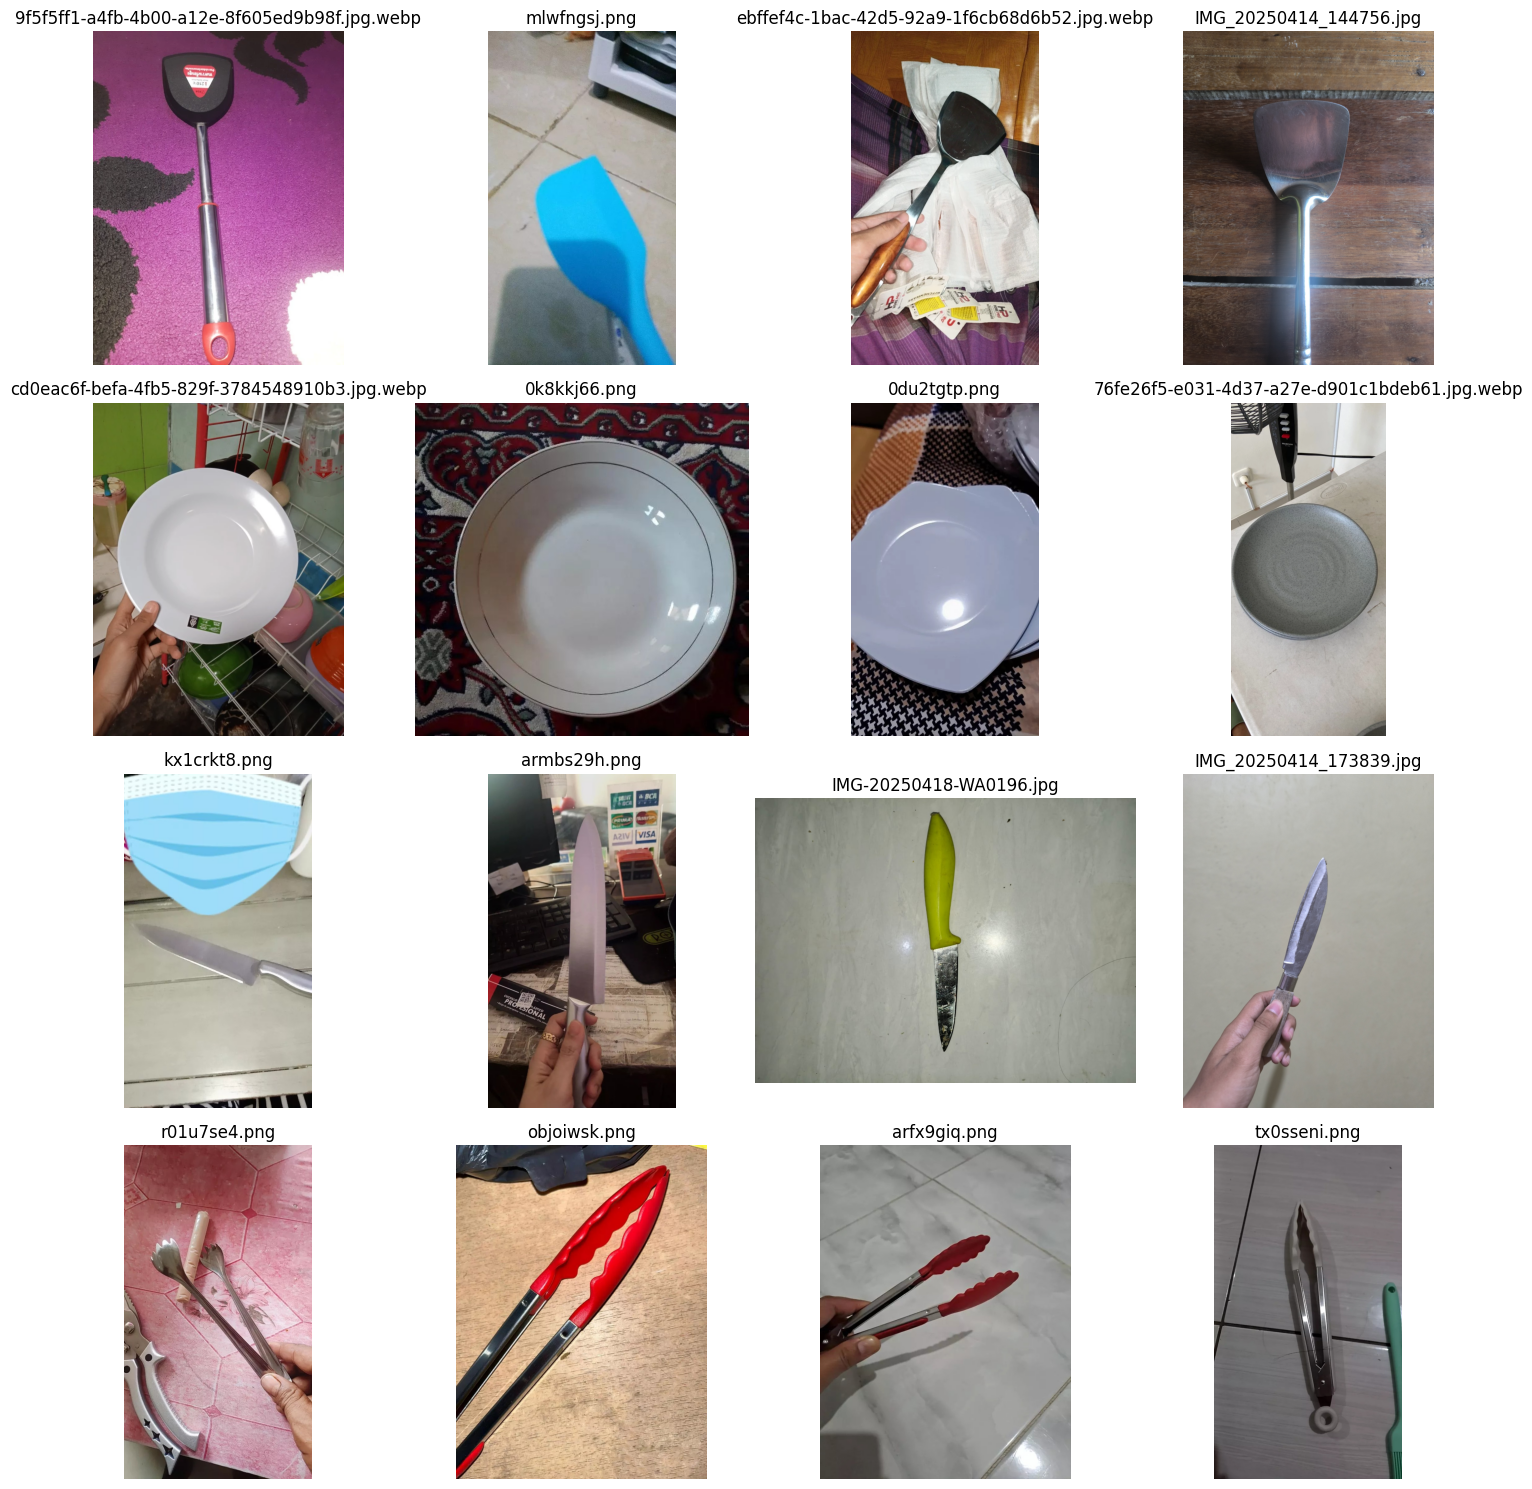

In [ ]:
# Cell 4: Visualize images from the dataset
# Function to display images
def plot_images(images, titles, rows=1, cols=4, figsize=(15, 5)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel() if rows > 1 else axes

    for idx, (image, title) in enumerate(zip(images, titles)):
        img = Image.open(image)
        axes[idx].imshow(img)
        axes[idx].set_title(title)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Sample 4 images from each class
samples = []
for cls in classes:
    cls_samples = df[df['label'] == cls].sample(4, random_state=42)['image_path'].values
    samples.extend(cls_samples)

plot_images(samples, [os.path.basename(img) for img in samples], rows=4, cols=4, figsize=(15, 15))

In [ ]:
# Cell 5: Define transforms and split dataset
# Define image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split dataset into train (70%), validation (15%), and test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Check class distribution in splits
print("\nTrain class distribution:")
print(train_df['label'].value_counts())
print("\nValidation class distribution:")
print(val_df['label'].value_counts())
print("\nTest class distribution:")
print(test_df['label'].value_counts())

Train size: 954
Validation size: 204
Test size: 205

Train class distribution:
label
Piring              276
penjepit makanan    238
Spatula             230
pisau dapur         210
Name: count, dtype: int64

Validation class distribution:
label
Piring              59
penjepit makanan    51
Spatula             49
pisau dapur         45
Name: count, dtype: int64

Test class distribution:
label
Piring              60
penjepit makanan    51
Spatula             49
pisau dapur         45
Name: count, dtype: int64


In [ ]:
# Cell 6: Create custom dataset class (DIPERBAIKI)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(classes)}

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['label']

        # Load gambar dengan error handling
        try:
            image = Image.open(img_path).convert('RGB')  # Pastikan convert ke RGB
        except:
            # Jika masih error, gunakan gambar dummy
            image = Image.new('RGB', (224, 224), color='black')
            print(f"Gagal load: {img_path}, menggunakan dummy image")

        if self.transform:
            image = self.transform(image)

        return image, self.label_to_idx[label]

    # TAMBAHKAN METHOD INI
    def __len__(self):
        return len(self.dataframe)  # Mengembalikan jumlah sampel dalam dataset

# Create datasets
train_dataset = CustomDataset(train_df, transform=train_transform)
val_dataset = CustomDataset(val_df, transform=val_test_transform)
test_dataset = CustomDataset(test_df, transform=val_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check one batch
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch labels: {labels}")

Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([2, 0, 3, 1, 1, 0, 0, 1, 2, 1, 1, 3, 3, 0, 1, 3, 0, 2, 3, 1, 1, 0, 3, 3,
        3, 0, 1, 3, 1, 1, 1, 3])


In [ ]:
# Cell 7: Mengganti ResNet dengan MobileNet
class AlatDapurClassifier(nn.Module):
    def __init__(self, num_classes=len(classes)):
        super(AlatDapurClassifier, self).__init__()

        # Menggunakan MobileNetV2 yang sudah dilatih sebelumnya
        self.base_model = models.mobilenet_v2(pretrained=True)

        # Membekukan semua layer kecuali classifier
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Mengganti classifier terakhir
        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

model = AlatDapurClassifier(num_classes=len(classes)).to(device)

# Print model summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
# Cell 8: Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

# Function to compute accuracy
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0
    best_model_weights = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_train / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = 100 * correct_val / total_val
        val_loss_history.append(val_epoch_loss)
        val_acc_history.append(val_epoch_acc)

        scheduler.step(val_epoch_loss)

        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_weights = model.state_dict()

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%')
        print('-' * 20)

    # Load best model weights
    model.load_state_dict(best_model_weights)
    print(f'Best Val Accuracy: {best_val_acc:.2f}%')

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Cell 9: Train the model
num_epochs = 50
trained_model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, criterion, optimizer, scheduler, num_epochs=num_epochs
)

# Save the trained model
torch.save(trained_model.state_dict(), 'flower_classifier_resnet50.pth')

Epoch 1/50
Train Loss: 1.2453, Acc: 45.07%
Val Loss: 0.6522, Acc: 81.86%
--------------------
Epoch 2/50
Train Loss: 0.7914, Acc: 67.92%
Val Loss: 0.5427, Acc: 79.41%
--------------------
Epoch 3/50
Train Loss: 0.7784, Acc: 69.81%
Val Loss: 0.4767, Acc: 82.35%
--------------------
Epoch 4/50
Train Loss: 0.6344, Acc: 75.16%
Val Loss: 0.3721, Acc: 87.25%
--------------------
Epoch 5/50
Train Loss: 0.6050, Acc: 77.57%
Val Loss: 0.3570, Acc: 87.75%
--------------------
Epoch 6/50
Train Loss: 0.6115, Acc: 77.15%
Val Loss: 0.5017, Acc: 78.43%
--------------------
Epoch 7/50
Train Loss: 0.5912, Acc: 76.62%
Val Loss: 0.3342, Acc: 87.75%
--------------------
Epoch 8/50
Train Loss: 0.5233, Acc: 79.56%
Val Loss: 0.4299, Acc: 83.33%
--------------------
Epoch 9/50
Train Loss: 0.5371, Acc: 79.35%
Val Loss: 0.4060, Acc: 84.80%
--------------------
Epoch 10/50
Train Loss: 0.5746, Acc: 77.57%
Val Loss: 0.3975, Acc: 85.29%
--------------------
Epoch 11/50
Train Loss: 0.5269, Acc: 79.45%
Val Loss: 0.329

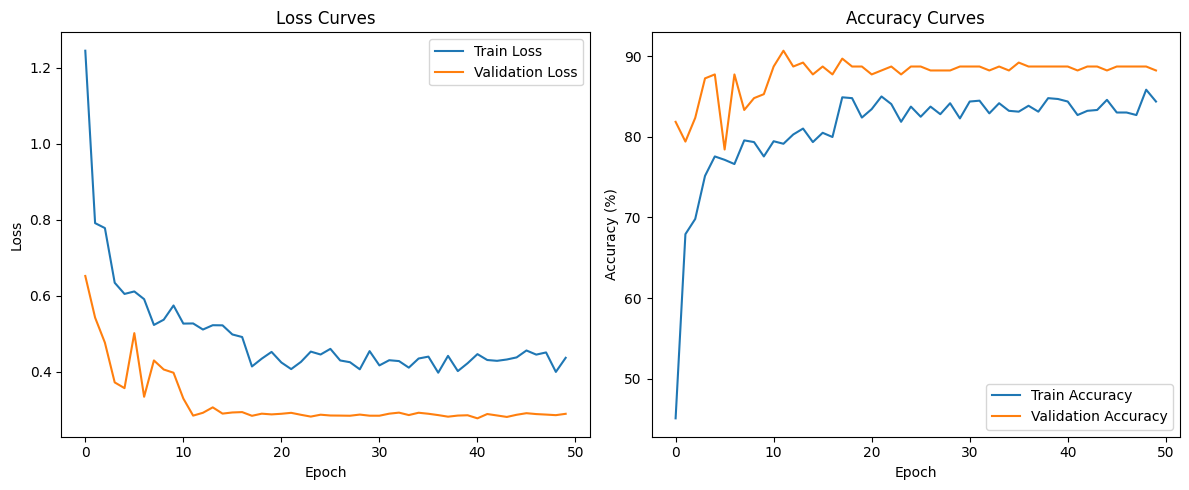

In [ ]:
# Cell 10: Plot training and validation loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

Test Loss: 0.2214, Test Accuracy: 92.68%

Classification Report:
                  precision    recall  f1-score   support

        Spatula        0.84      1.00      0.92        49
         Piring        0.98      0.98      0.98        60
     pisau dapur       1.00      0.82      0.90        45
penjepit makanan       0.90      0.88      0.89        51

        accuracy                           0.93       205
       macro avg       0.93      0.92      0.92       205
    weighted avg       0.93      0.93      0.93       205



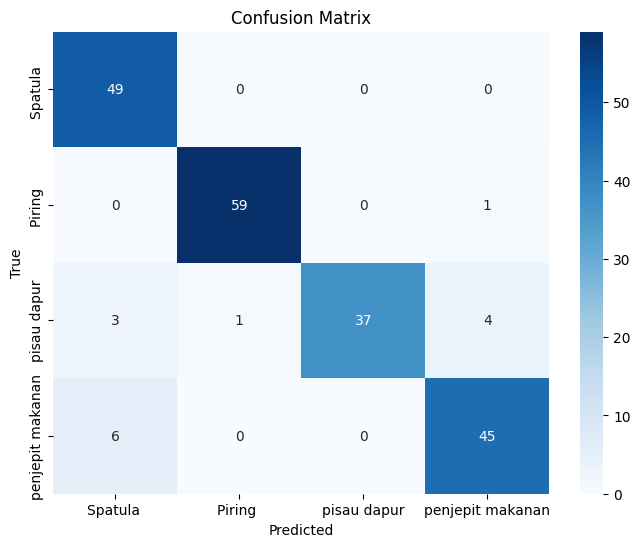

In [ ]:
# Cell 11: Evaluate on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return test_acc

test_accuracy = evaluate_model(trained_model, test_loader, device)

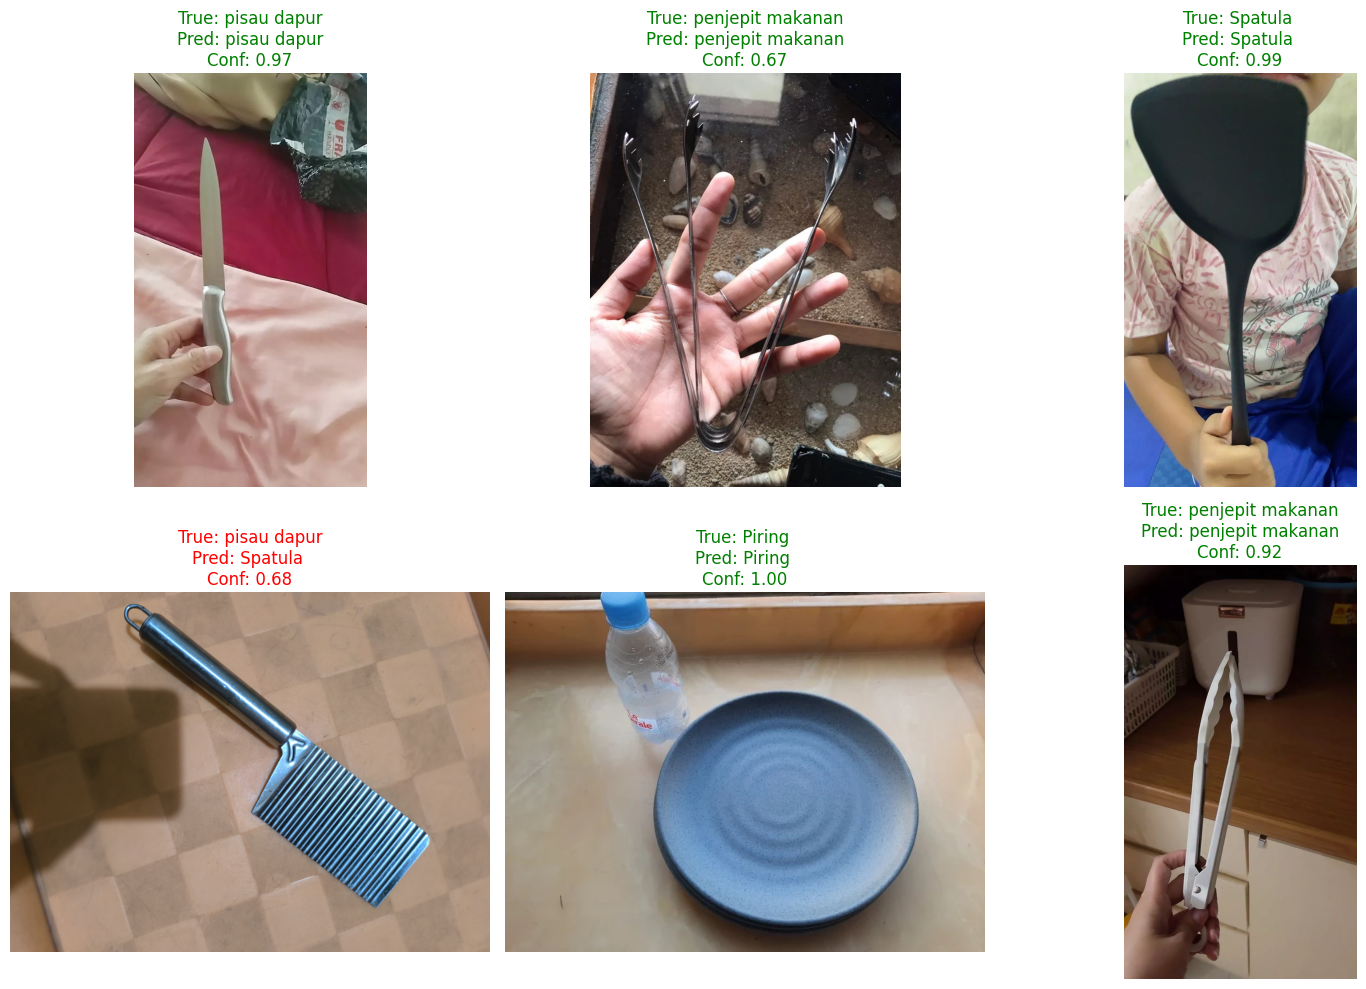

In [ ]:
# Cell 12: Make predictions on test images
def predict_image(model, image_path, transform, classes):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        conf, predicted_idx = torch.max(probabilities, 0)
        predicted_label = classes[predicted_idx.item()]

    return predicted_label, conf.item()

# Test on some sample images
sample_images = test_df.sample(6, random_state=42)['image_path'].values

plt.figure(figsize=(15, 10))
for idx, img_path in enumerate(sample_images):
    plt.subplot(2, 3, idx+1)
    image = Image.open(img_path)
    plt.imshow(image)

    predicted_label, confidence = predict_image(trained_model, img_path, val_test_transform, classes)
    true_label = test_df[test_df['image_path'] == img_path]['label'].values[0]

    title = f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(title, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 13: Grad-CAM Visualization (Fixed and Complete)
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Pasang hooks
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Cari target layer
        layer_found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(forward_hook)
                module.register_full_backward_hook(backward_hook)
                layer_found = True
                print(f"Successfully registered hooks for layer: {name}")
                break

        if not layer_found:
            raise ValueError(f"Target layer '{self.target_layer}' not found in model!")

    def generate_cam(self, input_tensor, target_class=None):
        # Pastikan model dalam eval mode
        self.model.eval()

        # Forward pass
        outputs = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(outputs)

        # Zero gradients
        self.model.zero_grad()

        # Siapkan one-hot encoding
        one_hot = torch.zeros_like(outputs)
        one_hot[0][target_class] = 1

        # Backward pass dengan retain_graph
        outputs.backward(gradient=one_hot, retain_graph=True)

        # Validasi gradients dan activations
        if self.gradients is None or self.activations is None:
            raise RuntimeError(
                "Gradients/activations not captured! "
                f"Gradients: {self.gradients}, Activations: {self.activations}. "
                "Check target layer name."
            )

        # Proses CAM
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Post-processing
        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))  # Resize ke ukuran input
        cam -= cam.min()
        cam /= cam.max() if cam.max() != 0 else 1  # Normalisasi [0, 1]
        return cam

def show_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # Unnormalize dulu
    img = img_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
    img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + img * (1 - alpha)

    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(overlay, 0, 1))
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

Total errors: 15
Error rate: 7.32%


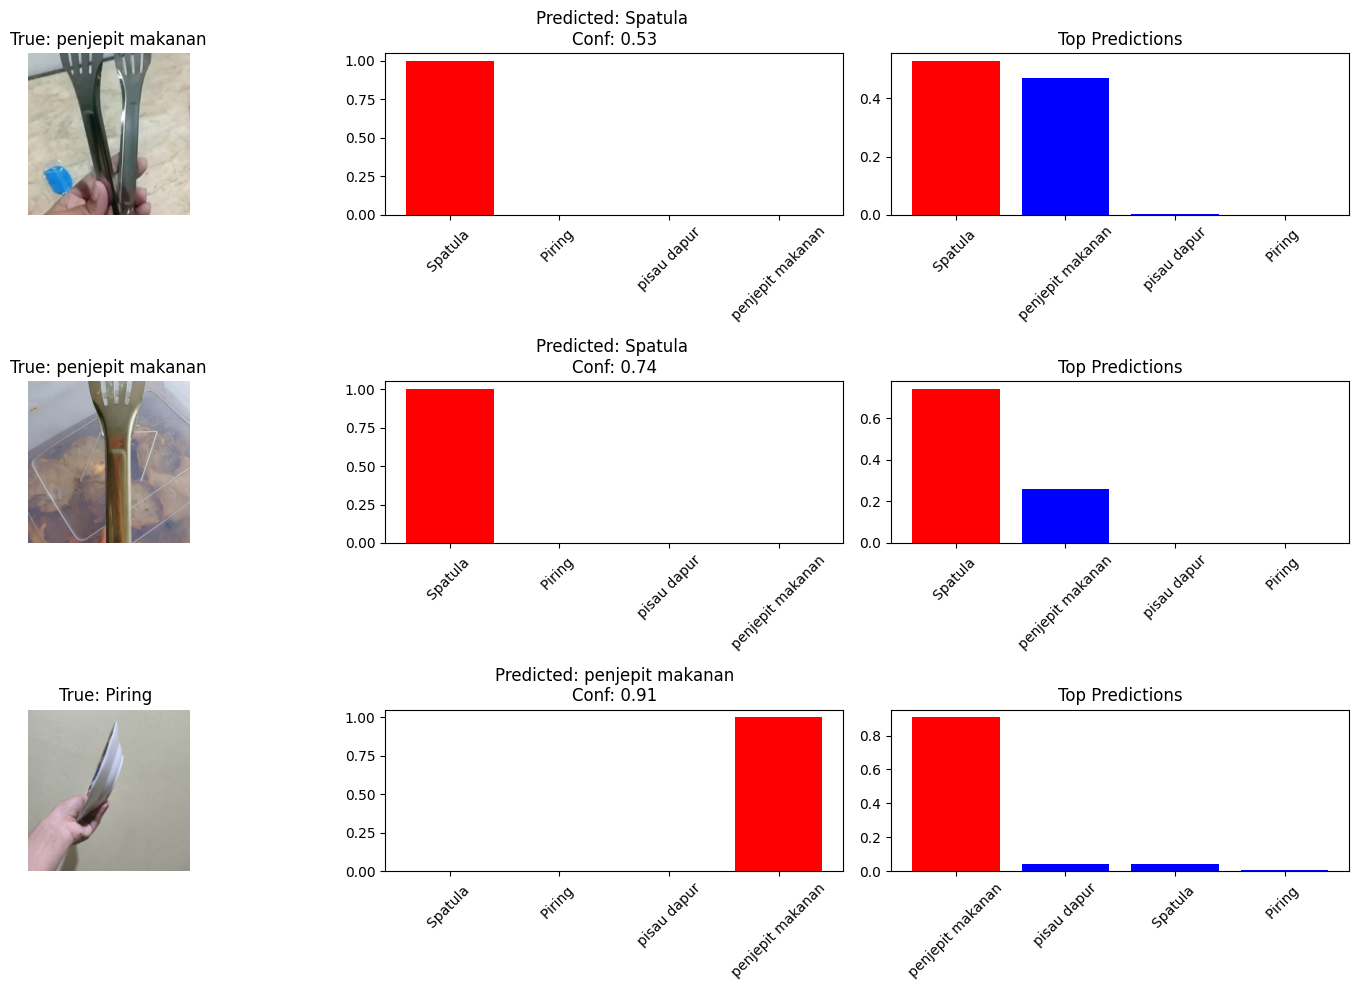

In [ ]:
# Cell 14: Compute Error Rate Analysis (Fixed)
def analyze_errors(model, test_loader, classes, device, top_k=5):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Get indices of incorrect predictions
            incorrect_mask = (preds != labels)
            incorrect_indices = torch.nonzero(incorrect_mask).squeeze()

            if incorrect_indices.numel() == 0:
                continue

            if incorrect_indices.numel() == 1:
                incorrect_indices = incorrect_indices.unsqueeze(0)

            # Get incorrect samples
            incorrect_inputs = inputs[incorrect_indices]
            incorrect_preds = preds[incorrect_indices]
            incorrect_labels = labels[incorrect_indices]

            # Get probabilities
            probabilities = torch.nn.functional.softmax(outputs[incorrect_indices], dim=1)

            for i in range(len(incorrect_indices)):
                true_label = incorrect_labels[i].item()
                pred_label = incorrect_preds[i].item()
                prob = probabilities[i][pred_label].item()

                # Prevent out-of-range topk
                num_classes = probabilities[i].shape[0]
                k = min(top_k, num_classes)

                # Get top-k predictions
                top_probs, top_indices = torch.topk(probabilities[i], k=k)
                top_probs = top_probs.cpu().numpy()
                top_indices = top_indices.cpu().numpy()

                errors.append({
                    'image': incorrect_inputs[i].cpu(),
                    'true_label': true_label,
                    'pred_label': pred_label,
                    'confidence': prob,
                    'top_predictions': list(zip(top_indices, top_probs))
                })

    return errors

# Get error cases
errors = analyze_errors(trained_model, test_loader, classes, device)

# Display some error cases
print(f"Total errors: {len(errors)}")
print(f"Error rate: {len(errors)/len(test_df)*100:.2f}%")

if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    for i in range(min(3, len(errors))):
        error = errors[i]
        image = error['image'].permute(1, 2, 0).numpy()
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        image = np.clip(image, 0, 1)

        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"True: {classes[error['true_label']]}")
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.bar(range(len(classes)), [0]*len(classes), color='lightgray')
        plt.bar(error['pred_label'], 1, color='red')
        plt.xticks(range(len(classes)), classes, rotation=45)
        plt.title(f"Predicted: {classes[error['pred_label']]}\nConf: {error['confidence']:.2f}")

        plt.subplot(3, 3, i*3 + 3)
        top_indices = [x[0] for x in error['top_predictions']]
        top_probs = [x[1] for x in error['top_predictions']]
        plt.bar(range(len(top_indices)), top_probs, color=['red' if i == error['pred_label'] else 'blue' for i in top_indices])
        plt.xticks(range(len(top_indices)), [classes[idx] for idx in top_indices], rotation=45)
        plt.title("Top Predictions")

    plt.tight_layout()
    plt.show()
